# Rock, Paper, Scissors

**Import Custom Scripts [Local Notebook]**

Use this import if you are running the notebook locally from the root directory of the github repository

In [1]:
# import tensorflow as tf
# import tensorflow_datasets as tfds
# import tensorflow_addons as tfa
# import matplotlib.pyplot as plt

# from pathlib import Path

# from lib.image_transforms import stateless_random_rotate, stateless_random_invert

**Import Custom Scripts [Google Colab]**

To use the custom scripts in Google Colab, clone the git repository to your local directory and use an absolute import statement.

Check out `./learning_tf/lib` for the custom functions used in this notebook

In [2]:
! pip install tensorflow-addons
! git clone https://github.com/junpeng-jp/learning_tensorflow ./learning_tensorflow

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from pathlib import Path

from learning_tensorflow.lib.image_transforms import stateless_random_rotate, stateless_random_invert

fatal: destination path './learning_tensorflow' already exists and is not an empty directory.


## Downloading Dataset

Tensorflow datasets is a library that provides user-friendly APIs to download many datasets available online. A convenient Split API is included that will split the downloaded files into `tf.record` files.

In [3]:
seed = 23916481831
tf.random.set_seed(seed)

In [4]:
builder = tfds.builder(
    'rock_paper_scissors',
    data_dir = "./data")

builder.download_and_prepare()

train, test = builder.as_dataset(
    split = ['train', 'test'],
    shuffle_files = True,
    read_config = tfds.ReadConfig(shuffle_seed = seed))

In [5]:
builder.info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [6]:
label_encoder = builder.info.features['label']

## Classifying CG Hands

The dataset provided uses a images of hands that were generated using computer graphics software. Most of the hand poses are slight variations in angles of a base CG hand and can potentially introduce some biases into the convolution model that we will be using.

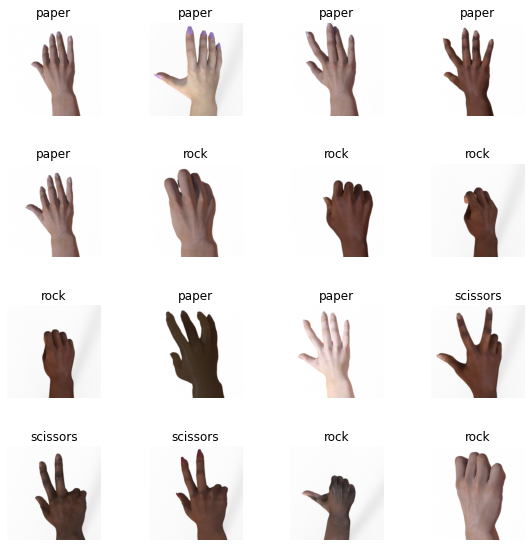

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
fig.tight_layout()

for ax, data in zip(axes.ravel(), train.take(16)):
    ax.imshow(data['image'].numpy())
    ax.set_title("{}".format(label_encoder.int2str(data['label'])))
    ax.axis("off")

In [8]:
IMG_SIZE = (256, 256)

DELTA_HUE = 0.3
DELTA_SATURATION = (0.8, 1.2)

DELTA_ROTATE = 45
DELTA_BRIGHTNESS = 0.1

PROB_THRESHOLD = 0.4

rng = tf.random.Generator.from_seed(seed)

def standardize_img(data):
    image, label = data['image'], data['label']
    image = tf.cast(image, tf.float64) / 255.
    image = tf.image.resize(image, IMG_SIZE) 
    label = tf.one_hot(label, depth = 3)
    
    return image, label

def unit_augmentation(image, label):
    rng_seed = rng.make_seeds(4)
    
    prob = tf.random.stateless_uniform(shape = [], seed = rng_seed[:, 0])
    
    if prob > PROB_THRESHOLD:
        image = tf.image.stateless_random_hue(image, DELTA_HUE, seed = rng_seed[:, 1])
        image = tf.image.stateless_random_saturation(image, *DELTA_SATURATION, seed = rng_seed[:, 2])
        image = tf.image.stateless_random_brightness(image, DELTA_BRIGHTNESS, seed = rng_seed[:, 3])

    return image, label

def batch_augmentation(image, label):
    rng_seed = rng.make_seeds(4)
    
    image = tf.image.stateless_random_flip_left_right(image, seed = rng_seed[:, 0])
    image = tf.image.stateless_random_flip_up_down(image, seed = rng_seed[:, 1])
    image = stateless_random_rotate(image, DELTA_ROTATE, fill_value=1., seed = rng_seed[:, 2])
    image = stateless_random_invert(image, prob_threshold = PROB_THRESHOLD, seed = rng_seed[:, 3])
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [9]:
BATCH_SIZE = 32

trainloader = (
    train
    .map(standardize_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .map(unit_augmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(batch_augmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

testloader = (
    test
    .map(standardize_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

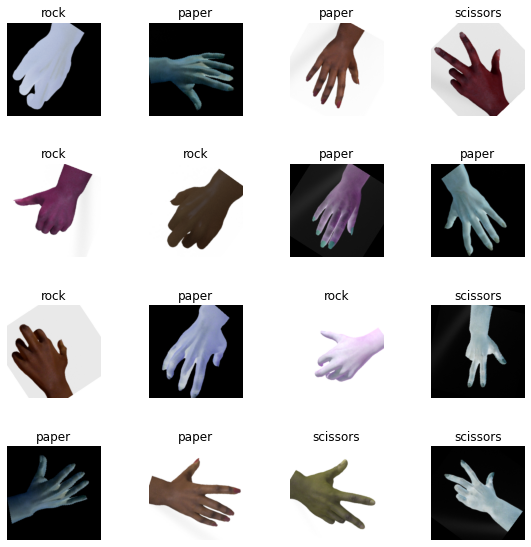

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
fig.tight_layout()

for img, label in trainloader.take(1):
    label = tf.argmax(label, axis = 1)
    for ax, i in zip(axes.ravel(), range(16)):
        ax.imshow(img[i].numpy())
        ax.set_title("{}".format(label_encoder.int2str(label[i])))
        ax.axis("off")

In [11]:
def block(n_filter):
    rng_seed = rng.make_seeds(1)[0, 0]
    blk = tf.keras.Sequential()

    blk.add(tf.keras.layers.Conv2D(
        n_filter, (3,3), 
        activation=tf.keras.layers.PReLU(), 
        padding='same', 
        kernel_initializer=tf.keras.initializers.HeNormal(seed = rng_seed)))
    
    blk.add(tf.keras.layers.MaxPool2D())
    blk.add(tf.keras.layers.BatchNormalization())

    return blk

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(*IMG_SIZE, 3)))

model.add(block(64))
model.add(block(64))
model.add(block(128))
model.add(block(128))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation=tf.keras.layers.PReLU()))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128, 128, 64)      4196352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 64)        1085760   
_________________________________________________________________
sequential_3 (Sequential)    (None, 32, 32, 128)       598656    
_________________________________________________________________
sequential_4 (Sequential)    (None, 16, 16, 128)       279168    
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16778240  
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2

In [14]:
# optimizer = tfa.optimizers.AdamW(0.01, learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model.compile(
    optimizer = optimizer, 
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

In [15]:
model.fit(
    trainloader,
    validation_data = testloader,
    epochs = 30)

Epoch 1/30
79/79 [==============================] - 42s 425ms/step - loss: 2.2871 - accuracy: 0.4712 - val_loss: 7.3569 - val_accuracy: 0.3333
Epoch 2/30
79/79 [==============================] - 28s 356ms/step - loss: 0.6847 - accuracy: 0.7162 - val_loss: 5.1669 - val_accuracy: 0.3333
Epoch 3/30
79/79 [==============================] - 28s 348ms/step - loss: 0.4785 - accuracy: 0.8088 - val_loss: 4.1661 - val_accuracy: 0.3333
Epoch 4/30
79/79 [==============================] - 28s 348ms/step - loss: 0.3976 - accuracy: 0.8392 - val_loss: 0.7345 - val_accuracy: 0.7634
Epoch 5/30
79/79 [==============================] - 29s 360ms/step - loss: 0.2243 - accuracy: 0.9202 - val_loss: 4.9623 - val_accuracy: 0.3414
Epoch 6/30
79/79 [==============================] - 28s 352ms/step - loss: 0.1972 - accuracy: 0.9244 - val_loss: 0.4395 - val_accuracy: 0.8790
Epoch 7/30
79/79 [==============================] - 28s 352ms/step - loss: 0.1376 - accuracy: 0.9448 - val_loss: 0.4292 - val_accuracy: 0.8495